In [114]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import skew

from sklearn.preprocessing import scale

%matplotlib inline



df_train = pd.read_csv("train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("macro.csv", parse_dates=['timestamp'])

df_train.head()

# =============================
# =============================
# cleanup
# brings error down a lot by removing extreme price per sqm
print(df_train.shape)
df_train.loc[df_train.full_sq == 0, 'full_sq'] = 30
df_train = df_train[df_train.price_doc/df_train.full_sq <= 600000]
df_train = df_train[df_train.price_doc/df_train.full_sq >= 10000]
print(df_train.shape)
# =============================
# =============================

(30471, 292)
(30404, 292)


In [115]:
df_train = df_train[(df_train['timestamp'] >= '2013-7-1')]

In [116]:
#############################
# df_train = df_train.loc[df_train['build_year'].notnull(),:]
#############################

y_train = df_train['price_doc'].values
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)



# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)    # save so can separate later
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)



# ==============================
# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)


# Feature engineering
df_all['kitch_life'] = df_all.kitch_sq/df_all.life_sq
df_all['extra_on_life'] = df_all.full_sq/df_all.life_sq
df_all['rel_floor'] = df_all.floor/df_all.max_floor



# Separate dtypes
df_numeric = df_all.select_dtypes(exclude=['object'])    
df_obj = df_all.select_dtypes(include=['object']).copy()


# Deal with categorical values
for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]    # how is this different from above????


# Log transform skewed numeric features 
get_col = df_numeric.dtypes[(df_numeric.dtypes == "int64") | (df_numeric.dtypes == "float64")].index
get_skews = df_numeric[get_col].apply(lambda x: skew(x.dropna()))
get_skews = get_skews[get_skews>0.5]
get_skews = get_skews.index
df_numeric[get_skews] = np.log1p(df_numeric[get_skews])       




# concatenate back    
df_values = pd.concat([df_numeric, df_obj], axis=1)


important = ['full_sq', 'floor', 'max_floor', 'material', 'num_room', 'kitch_sq',
       'state', 'school_education_centers_raion',
       'healthcare_centers_raion', '7_14_female', '16_29_female',
       'build_count_1921-1945', 'metro_min_avto', 'metro_min_walk',
       'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km',
       'green_zone_km', 'incineration_km',
       'public_transport_station_min_walk', 'sadovoe_km', 'kremlin_km',
       'ID_big_road1', 'ID_big_road2', 'ID_railroad_terminal',
       'oil_chemistry_km', 'radiation_km', 'fitness_km', 'swim_pool_km',
       'ice_rink_km', 'stadium_km', 'public_healthcare_km',
       'workplaces_km', 'additional_education_km', 'big_church_km',
       'church_synagogue_km', 'mosque_km', 'theater_km', 'exhibition_km',
       'catering_km', 'green_part_500', 'office_count_500',
       'office_sqm_500', 'trc_sqm_500', 'cafe_sum_500_max_price_avg',
       'cafe_count_500_price_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_2500',
       'cafe_count_500_price_4000', 'cafe_count_500_price_high',
       'church_count_500', 'mosque_count_500', 'leisure_count_500',
       'sport_count_500', 'market_count_500', 'prom_part_1000',
       'trc_sqm_1000', 'cafe_count_1000_price_2500',
       'cafe_count_1000_price_high', 'church_count_1000',
       'leisure_count_1000', 'green_part_1500', 'prom_part_1500',
       'office_sqm_1500', 'trc_count_1500', 'cafe_sum_1500_max_price_avg',
       'cafe_count_1500_price_1500', 'cafe_count_1500_price_4000',
       'big_church_count_1500', 'mosque_count_1500', 'market_count_1500',
       'prom_part_2000', 'trc_count_2000', 'cafe_count_2000_price_1000',
       'big_church_count_2000', 'church_count_2000', 'mosque_count_2000',
       'leisure_count_2000', 'sport_count_2000', 'prom_part_3000',
       'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000',
       'cafe_count_3000_na_price', 'cafe_count_3000_price_1500',
       'big_church_count_3000', 'mosque_count_3000', 'trc_count_5000',
       'cafe_sum_5000_min_price_avg', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_high', 'kitch_life', 'extra_on_life',
       'rel_floor', 'month_year_cnt', 'rts', 'micex_rgbi_tr', 'cpi',
       'product_type', 'sub_area','oil_chemistry_raion', 'water_1line', 'big_road1_1line',
       'railroad_1line']




df_values = df_values[important]



# df = df_values.dropna()


# # select continuous numeric columns
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# num_df = df.select_dtypes(include=numerics)
# num_df.shape # 364 features


# impute missing values with mean
df_values = df_values.apply(lambda x: x.fillna(x.mean()),axis=0) # newdf is the numeric columns


# # scale the data frame
# df = (df - df.mean()) / (df.max() - df.min())


(29301, 390)


(29301L, 106L)
[0]	train-rmse:8.54996e+06	test-rmse:8.56186e+06
[1]	train-rmse:8.21951e+06	test-rmse:8.24537e+06
[2]	train-rmse:7.89744e+06	test-rmse:7.93705e+06
[3]	train-rmse:7.58364e+06	test-rmse:7.63624e+06
[4]	train-rmse:7.30088e+06	test-rmse:7.36907e+06
[5]	train-rmse:7.03469e+06	test-rmse:7.12012e+06
[6]	train-rmse:6.75761e+06	test-rmse:6.85874e+06
[7]	train-rmse:6.522e+06	test-rmse:6.63843e+06
[8]	train-rmse:6.29371e+06	test-rmse:6.42638e+06
[9]	train-rmse:6.07669e+06	test-rmse:6.22376e+06
[10]	train-rmse:5.85468e+06	test-rmse:6.02199e+06
[11]	train-rmse:5.64887e+06	test-rmse:5.83601e+06
[12]	train-rmse:5.45758e+06	test-rmse:5.66025e+06
[13]	train-rmse:5.28767e+06	test-rmse:5.50973e+06
[14]	train-rmse:5.12415e+06	test-rmse:5.36493e+06
[15]	train-rmse:4.97041e+06	test-rmse:5.22934e+06
[16]	train-rmse:4.81167e+06	test-rmse:5.09032e+06
[17]	train-rmse:4.67864e+06	test-rmse:4.97642e+06
[18]	train-rmse:4.55185e+06	test-rmse:4.86833e+06
[19]	train-rmse:4.41633e+06	test-rmse:4.75341e+

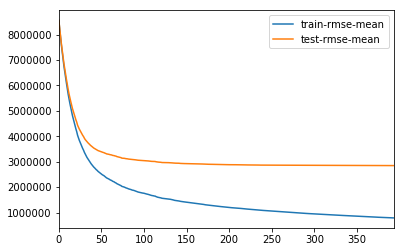

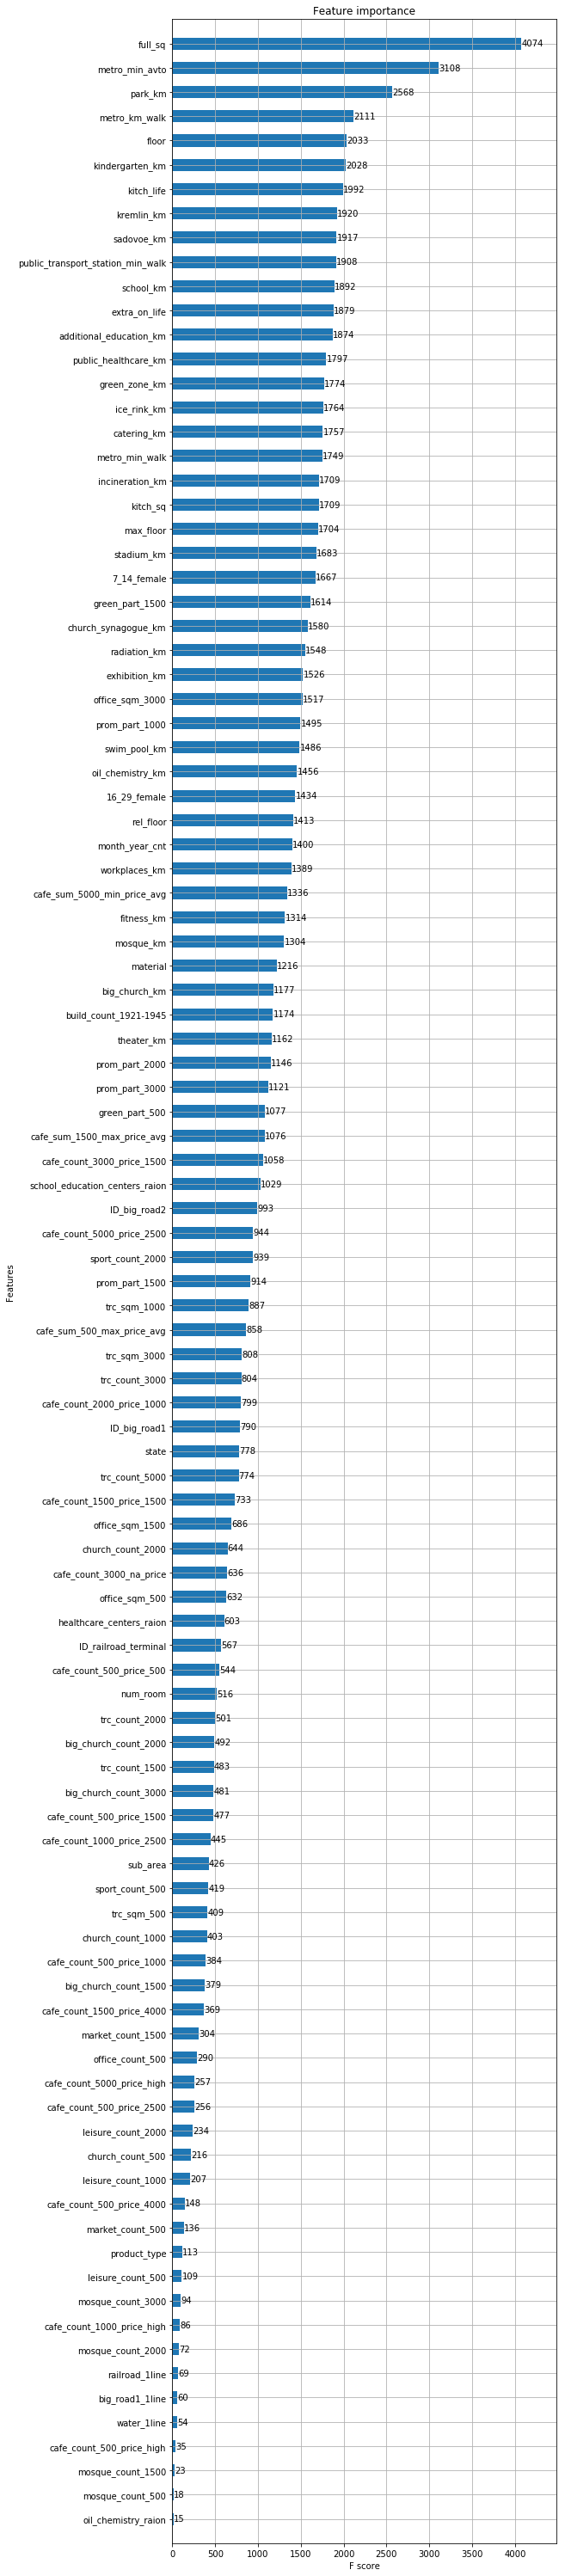

In [117]:

# Convert to numpy values
X_all = df_values.values
print(X_all.shape)


# Set the training and test sets
X_train = X_all[:num_train]
X_test = X_all[num_train:]


# Save the column names for features names
df_columns = df_values.columns


# Set the parameters
xgb_params = {
    'eta': 0.05,   # 0.05 orig
    'max_depth': 10,    # 5 orig
    'subsample': 0.5,     # 0.7 orig
    'colsample_bytree': 0.1,     # 0.7 orig
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',
    'silent': 1
}

# Train the set against the actual prices and then mak predictions
dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)


# Tune XGB `num_boost_rounds`
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

# num_boost_rounds = 489


# Run the model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)


# Plot the feature importance
fig, ax = plt.subplots(1, 1, figsize=(8, 54))
xgb.plot_importance(model, height=0.5, ax=ax)


# Make the predictions
y_pred = model.predict(dtest)
y_pred = np.round(y_pred * 0.95)
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})


# Save the csv
df_sub.to_csv('sub_param_tuned_3_pradeep.csv', index=False)

In [118]:
# Inspect results
df_sub_orig = pd.read_csv('sub_orig.csv')
print(df_sub.mean())
print(df_sub_orig.mean())

id           3.430450e+04
price_doc    7.198494e+06
dtype: float64
id           3.430450e+04
price_doc    7.362361e+06
dtype: float64


In [119]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 54))
# xgb.plot_importance(model, height=0.5, ax=ax);